In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
window = 5
train_split = 0.7
batch_size = 8
lr = 1e-3
num_epochs = 1500
print_every = 100
train_losses = list()

In [3]:
data = pd.read_csv('./Device_12_ecm_resampled_1D.csv')

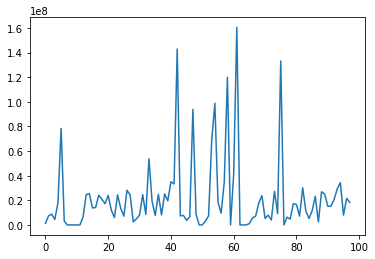

In [4]:
data = data.iloc[:,1:2].values
plt.plot(data)
plt.show()

In [5]:
def split_sequence(sequence, n_steps):

    X, y = list(), list()

    for i in range(len(sequence)):
        end_ix = i + n_steps

        if end_ix > len(sequence)-1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]

        X.append(seq_x)
        y.append(seq_y)

    return np.array(X), np.array(y)

In [6]:
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

copied_data = data.copy()

X, y = split_sequence(copied_data, window)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, shuffle=False)

train_set = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_set = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=True)

In [8]:
class LSTM(nn.Module):
    """Long Short Term Memory"""
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=False):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidirectional)

        if self.bidirectional:
            self.fc = nn.Linear(hidden_size * 2, output_size)
        else:
            self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return out
    
model = LSTM(input_size=1, hidden_size=10, num_layers=1, output_size=1, bidirectional=False).to(device)

In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))

In [10]:
for epoch in range(num_epochs):
    for i, (data, label) in enumerate(train_loader):

        data = data.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.float32)
        
        pred = model(data)
        
        train_loss = criterion(pred, label)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        train_losses.append(train_loss.item())
    
    if (epoch+1) % print_every == 0:
        
        print("Epoch [{}/{}]".format(epoch + 1, num_epochs))
        print("Train")
        print("Loss : {:.4f}".format(np.average(train_losses)))

Epoch [100/1500]
Train
Loss : 0.0392
Epoch [200/1500]
Train
Loss : 0.0377
Epoch [300/1500]
Train
Loss : 0.0353
Epoch [400/1500]
Train
Loss : 0.0326
Epoch [500/1500]
Train
Loss : 0.0303
Epoch [600/1500]
Train
Loss : 0.0284
Epoch [700/1500]
Train
Loss : 0.0268
Epoch [800/1500]
Train
Loss : 0.0255
Epoch [900/1500]
Train
Loss : 0.0244
Epoch [1000/1500]
Train
Loss : 0.0235
Epoch [1100/1500]
Train
Loss : 0.0226
Epoch [1200/1500]
Train
Loss : 0.0217
Epoch [1300/1500]
Train
Loss : 0.0209
Epoch [1400/1500]
Train
Loss : 0.0202
Epoch [1500/1500]
Train
Loss : 0.0195


In [11]:
model.eval()

with torch.no_grad():
    for i, (data, label) in enumerate(test_loader):

        data = data.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.float32)

        pred_test = model(data)

        pred_test = pred_test.data.cpu().numpy()
        label = label.data.cpu().numpy()

        pred_test = scaler.inverse_transform(pred_test)
        label = scaler.inverse_transform(label)

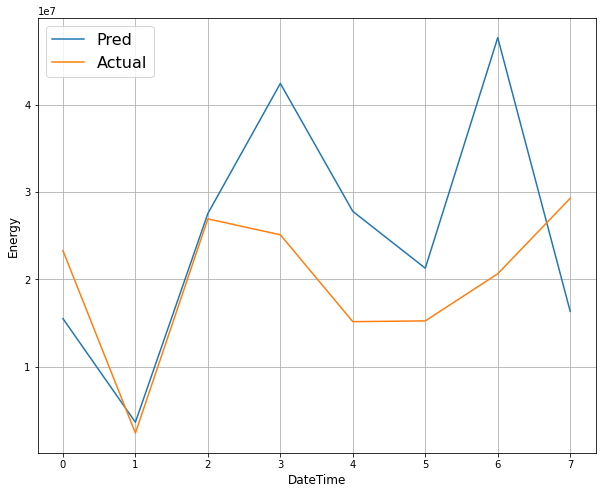

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(pred_test, label='Pred')
plt.plot(label, label='Actual')

plt.xlabel('DateTime', fontsize=12)
plt.xticks()
plt.ylabel('Energy', fontsize=12)
plt.grid()
plt.legend(fontsize=16)